In [1]:
import numpy as np 
import xarray as xr
import pandas as pd 
import os.path
import matplotlib.pyplot as plt 

In [2]:
# set parameters for each run
nmem = 1  # memory time steps
yrsta = 1979  # starting year in training
varnum = 19  # number of input maps
yrlen = 36  # how many years in the training dataset. 94 is actually 114. 
flg = 'trop'  # 'trop' means [-20, 20], '60deg' means [-60, 60]

fnROMI = '/global/homes/l/linyaoly/ERA5/reanalysis/cal_ROMI/ROMI_ERA5_daily_'+str(yrsta)+'to2021.nc'  # file path for the obs ROMI
dirn = '/global/homes/l/linyaoly/ERA5/script/Unet4MJO/'+str(varnum)+'maps_MCDO_'+str(yrlen)+'yrtraining_ROMIERA5_filtered_'+flg+'/output/'  # directory path for the output

lead = [1, 5, 10, 13, 15, 20, 25, 30]   # select the prediction lead


In [3]:
def get_phase(RMM1, RMM2):
    if RMM1>=0 and RMM2>=0 and RMM1>=RMM2:
        return 5
    elif RMM1>=0 and RMM2>=0 and RMM1<=RMM2:
        return 6
    elif RMM1<=0 and RMM2>=0 and -RMM1<=RMM2:
        return 7
    elif RMM1<=0 and RMM2>=0 and -RMM1>=RMM2:
        return 8 
    elif RMM1<=0 and RMM2<=0 and RMM1<=RMM2:
        return 1
    elif RMM1<=0 and RMM2<=0 and RMM1>=RMM2:
        return 2 
    elif RMM1>=0 and RMM2<=0 and RMM1<=-RMM2:
        return 3
    elif RMM1>=0 and RMM2<=0 and RMM1>=-RMM2:
        return 4

In [4]:
# get initial phase
iniROMI = xr.open_dataset(fnROMI)

if nmem == 1:
    a = iniROMI.sel(time=slice('2015-01-01','2016-12-30'))
    b = iniROMI.sel(time=slice('2017-01-01','2019-12-31'))
elif nmem == 30:
    a = iniROMI.sel(time=slice('2015-01-30','2017-01-28'))
    b = iniROMI.sel(time=slice('2017-01-30','2020-01-29'))

iniROMI = xr.concat((a,b), dim='time')
del a 
del b 
ROMI1 = iniROMI['ROMI'][:,0]
ROMI2 = iniROMI['ROMI'][:,1]
Phase = np.zeros(len(ROMI1))

for i in np.arange(len(ROMI1)):
    Phase[i] = get_phase(ROMI2[i],-ROMI1[i])

# Phase

In [5]:
# analyze error source
RMSE = []
err  = []
ds = []
pha_err = []
BCC = []

for ilead, leadmjo in zip(np.arange(len(lead)), lead): 
    # combine 2015-2019 prediction for the lead
    dsp = []
    dst = []
    dspstd = []

    for yn in np.arange(2015,2020):
        fnp=dirn + 'predicted_MCDO_UNET_'+str(varnum)+'maps'+flg+'_ROMIERA5_'+str(yrlen)+'yr_lead' + str(leadmjo) + '_dailyinput_mem'+str(nmem)+'d' + str(yn) + '.csv'
        fnt=dirn + 'truth_MCDO_UNET_'+str(varnum)+'maps'+flg+'_ROMIERA5_'+str(yrlen)+'yr_lead' + str(leadmjo) + '_dailyinput_mem'+str(nmem)+'d' + str(yn) + '.csv'
        fnpstd=dirn + 'predicted_disstd_MCDO_UNET_'+str(varnum)+'maps'+flg+'_ROMIERA5_'+str(yrlen)+'yr_lead' + str(leadmjo) + '_dailyinput_mem'+str(nmem)+'d' + str(yn) + '.csv'

        df = pd.read_csv(fnp,index_col=None, header=None, names=['ROMIp1','ROMIp2'])
        dsp.append(df)
        del df 
        df = pd.read_csv(fnt,index_col=None, header=None, names=['ROMIt1','ROMIt2'])
        dst.append(df)
        del df 
        df = pd.read_csv(fnpstd,index_col=None, header=None, names=['std1','std2'])
        dspstd.append(df)
        del df 

    dsp0 = pd.concat(dsp, axis=0, ignore_index=True)
    dst0 = pd.concat(dst, axis=0, ignore_index=True)
    dspstd0 = pd.concat(dspstd, axis=0, ignore_index=True)

    ds0 = pd.concat((dsp0,dst0,dspstd0), axis=1)

    ds.append(ds0)
    del ds0
        
    iniROMI = xr.open_dataset(fnROMI)
    
    if nmem == 1:
        a = iniROMI.sel(time=slice('2015-01-01','2016-12-30'))
        b = iniROMI.sel(time=slice('2017-01-01','2019-12-31'))
    elif nmem == 30:
        a = iniROMI.sel(time=slice('2015-01-30','2017-01-28'))
        b = iniROMI.sel(time=slice('2017-01-30','2020-01-29'))

    iniROMI = xr.concat((a,b), dim='time')
    del a 
    del b 
    ROMI1 = iniROMI['ROMI'][:,0]
    ROMI2 = iniROMI['ROMI'][:,1]
    IniAmp = np.sqrt(ROMI1 * ROMI1 + ROMI2 * ROMI2)
    ds[ilead]['IniAmp'] = IniAmp.values 
    ds[ilead]['time'] =  iniROMI.time.values
    ds[ilead]['month'] = pd.DatetimeIndex(ds[ilead].time).month
    ds[ilead]['Phase'] = Phase

    std1 = ds[ilead]['std1']
    std2 = ds[ilead]['std2']
    std = np.sqrt(std1*std1+std2*std2)
    ds[ilead]['std'] = std.values

    # finish combination
    # evaluation starts 
    ds0 = ds[ilead].copy()
    dstmp = ds0.loc[ds0['IniAmp']>=1]
    ds[ilead] = dstmp.copy()
    del ds0 
    del dstmp

    r1p = np.asarray(ds[ilead]['ROMIp1'])
    r2p = np.asarray(ds[ilead]['ROMIp2'])
    r1t = np.asarray(ds[ilead]['ROMIt1'])
    r2t = np.asarray(ds[ilead]['ROMIt2'])
    std = np.asarray(ds[ilead]['std'])

    # BCC
    a = sum(r1p*r1t+r2p*r2t)
    b = np.sqrt(sum(r1t*r1t+r2t*r2t))
    c = np.sqrt(sum(r1p*r1p+r2p*r2p))
    BCC.append(a/b/c) 

    d = (r1t-r1p)*(r1t-r1p)+(r2t-r2p)*(r2t-r2p)
    ds[ilead]['RMSE'] = np.sqrt(d)
    RMSE.append(np.sqrt(d))  # RMSE at each time step
    err.append(std)

    a = r1t * r2p - r2t * r1p 
    b = r1t * r1p + r2t * r2p
    c = a / b 
    d = np.arctan(c) * 180. / np.pi
    ds[ilead]['pha_err'] = d
    pha_err.append(d)



(0.2, 1.1)

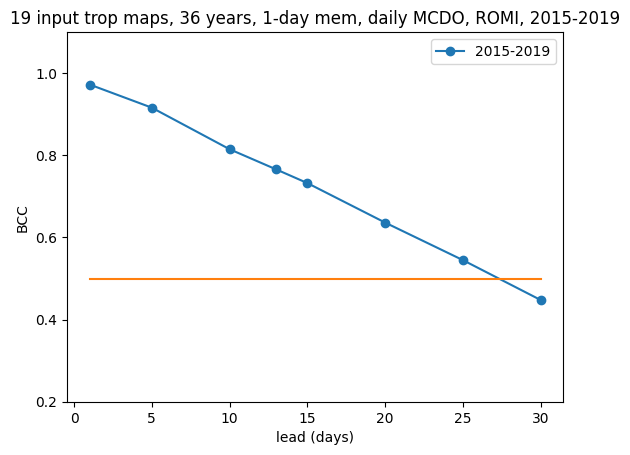

In [6]:
import matplotlib.pyplot as plt 

plt.plot(lead, BCC, 'o-', label='2015-2019')
plt.plot(lead, 0.5 * np.ones(len(lead)))
plt.legend()
if yrlen == 94:
    yrlen = 114
plt.title(str(varnum)+' input '+flg+' maps, '+str(yrlen)+' years, 1-day mem, daily MCDO, ROMI, 2015-2019')
plt.xlabel('lead (days)')
plt.ylabel('BCC')
plt.ylim([0.2,1.1])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


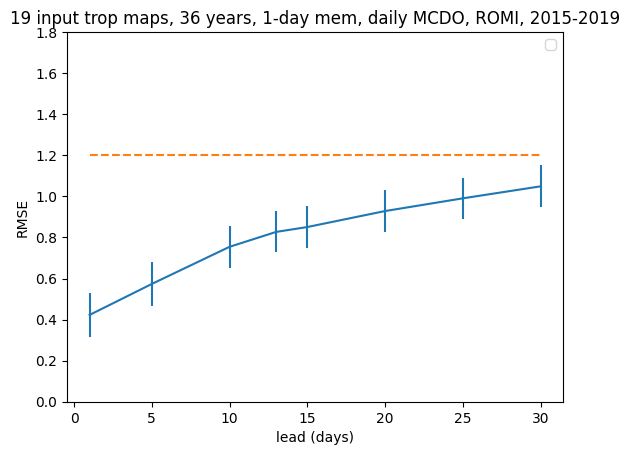

In [7]:
import matplotlib.pyplot as plt 
avRMSE = np.mean(RMSE,axis=1)
averr = np.mean(err,axis=1)
plt.errorbar(lead, avRMSE, yerr=averr/2.0)
# plt.plot([1,3,5,10,15,20,25,30], 1.2 * np.ones(8))
plt.legend()
plt.title(str(varnum)+' input '+flg+' maps, '+str(yrlen)+' years, 1-day mem, daily MCDO, ROMI, 2015-2019')
plt.xlabel('lead (days)')
plt.ylabel('RMSE')
plt.ylim([0,1.8])
plt.plot(lead,1.2*np.ones(len(lead)),'--')

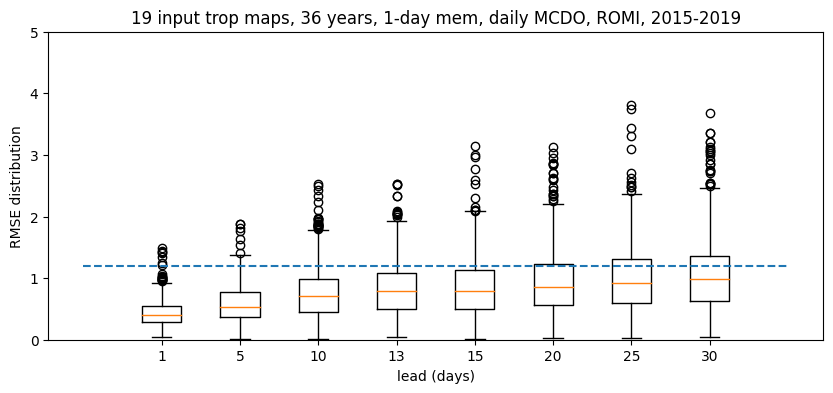

In [8]:
# ds[ilead]['time']
fig, ax = plt.subplots(figsize=(10,4))
ax.boxplot(RMSE)
ax.set_xticklabels(lead)
plt.xlabel('lead (days)')
plt.ylabel('RMSE distribution')
plt.ylim([0,5])
plt.title(str(varnum)+' input '+flg+' maps, '+str(yrlen)+' years, 1-day mem, daily MCDO, ROMI, 2015-2019')
ax.plot(np.arange(len(lead)+2),1.2*np.ones(len(lead)+2),'--')

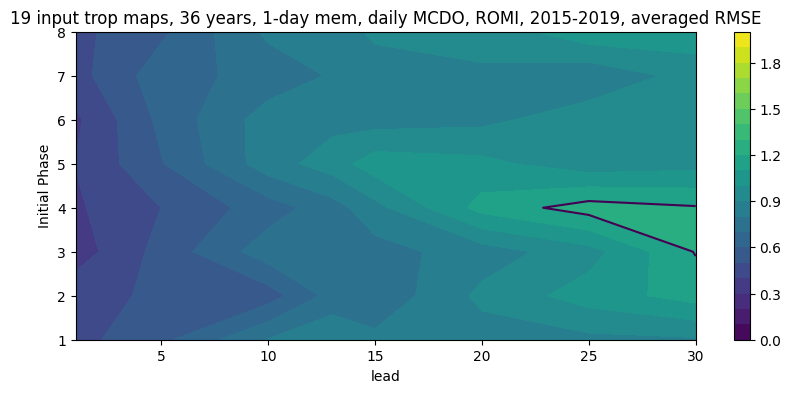

In [9]:
# lead and phase plot
ds1 = ds.copy()
RMSE_pha = np.zeros((len(lead),8))  # RMSE associated with 8 phases
fig, ax = plt.subplots(figsize=(10,4))
for ilead, leadmjo in zip(np.arange(len(lead)), lead):
    RMSE_pha[ilead,:] = ds1[ilead].groupby(['Phase']).mean()['RMSE']

del ds1
h = ax.contourf(lead, np.arange(1,9), np.transpose(RMSE_pha), levels = np.linspace(0,2,21))
# ax.legend(ncol=len(lead))
ax.set_xlabel('lead')
ax.set_ylabel('Initial Phase')
ax.set_title(str(varnum)+' input '+flg+' maps, '+str(yrlen)+' years, 1-day mem, daily MCDO, ROMI, 2015-2019, averaged RMSE')
plt.colorbar(h)
ax.contour(lead, np.arange(1,9), np.transpose(RMSE_pha),[1.2])

(0.0, 5.0)

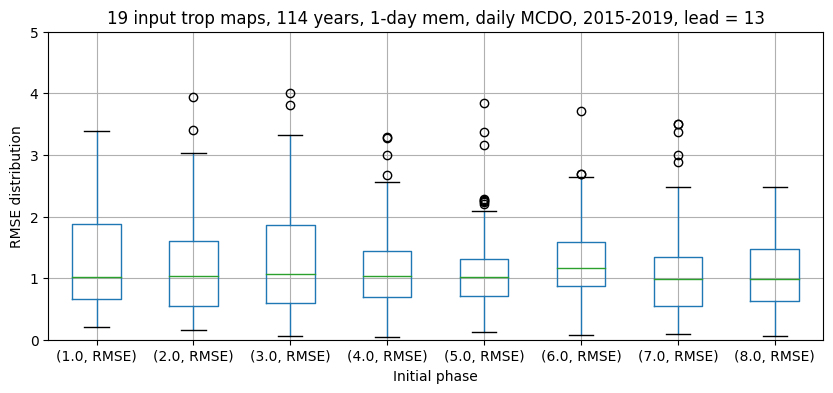

In [10]:
# for lead = 15 how the error depends on initial phase?
fig, ax = plt.subplots(figsize=(10,4))
# ax.plot(ds1[ilead].count()['std'], 'o', label=leadmjo)
ds[3].groupby(['Phase']).boxplot(subplots=False, column='RMSE')
# ax.set_xticklabels(lead)
plt.xlabel('Initial phase')
plt.ylabel('RMSE distribution')
plt.title(str(varnum)+' input '+flg+' maps, '+str(yrlen)+' years, 1-day mem, daily MCDO, 2015-2019, lead = 13')
# ax.plot(np.arange(11),1.2*np.ones(11),'--')
plt.ylim([0,5])

(-100.0, 100.0)

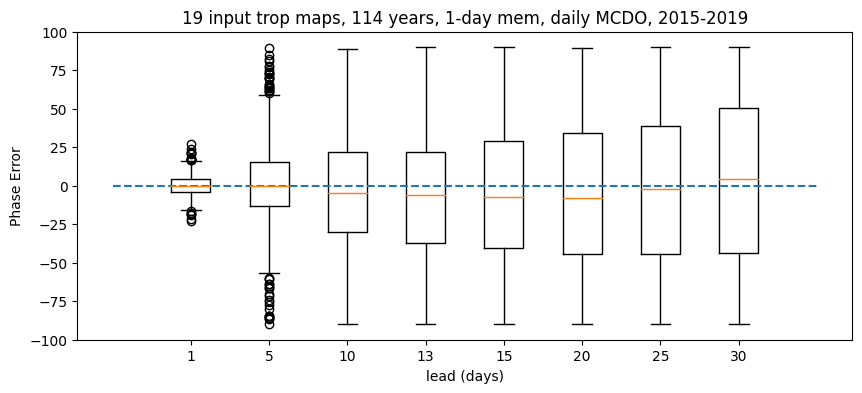

In [11]:
fig, ax = plt.subplots(figsize=(10,4))
ax.boxplot(pha_err)
ax.set_xticklabels(lead)
plt.xlabel('lead (days)')
plt.ylabel('Phase Error')
plt.title(str(varnum)+' input '+flg+' maps, '+str(yrlen)+' years, 1-day mem, daily MCDO, 2015-2019')
ax.plot(np.arange(len(lead)+2),np.zeros(len(lead)+2),'--')
plt.ylim([-100,100])

Text(0.5, 1.0, '19 input trop maps, 114 years, 1-day mem, daily MCDO, 2015-2019')

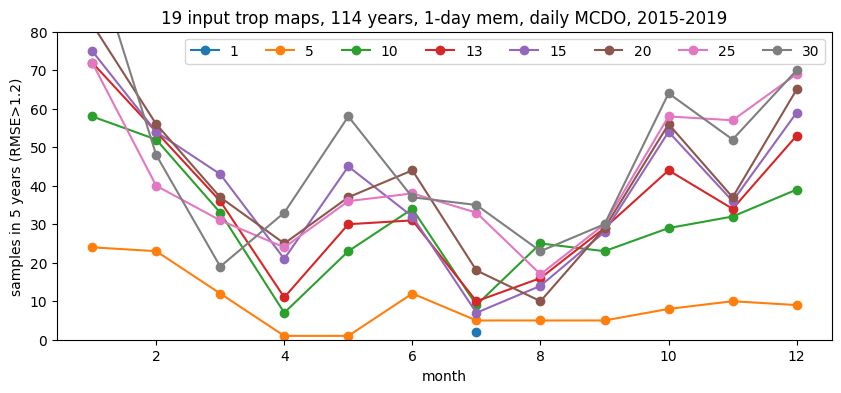

In [12]:
ds1 = ds.copy()
fig, ax = plt.subplots(figsize=(10,4))
for ilead, leadmjo in zip(np.arange(0, len(lead)), lead):
    ds1[ilead] = ds[ilead].loc[ds[ilead]['RMSE']>=1.2]
    ax.plot(ds1[ilead].groupby(['month']).count()['std'], 'o-', label=leadmjo)

ax.legend(ncol=len(lead))
ax.set_xlabel('month')
ax.set_ylim([0,80])
ax.set_ylabel('samples in 5 years (RMSE>1.2)')
ax.set_title(str(varnum)+' input '+flg+' maps, '+str(yrlen)+' years, 1-day mem, daily MCDO, 2015-2019')

Text(0.5, 1.0, '19 input trop maps, 114 years, 1-day mem, daily MCDO, 2015-2019')

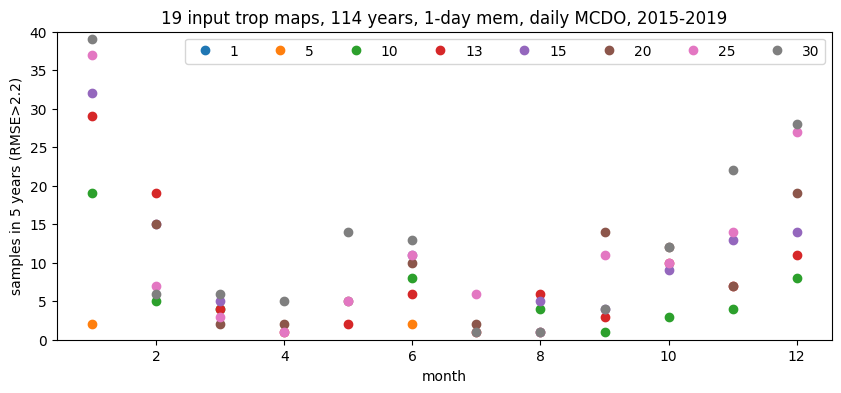

In [13]:
del ds1 
ds1 = ds.copy()
fig, ax = plt.subplots(figsize=(10,4))
for ilead, leadmjo in zip(np.arange(0, len(lead)), lead):
    ds1[ilead] = ds[ilead].loc[ds[ilead]['RMSE']>=2.2]
    ax.plot(ds1[ilead].groupby(['month']).count()['std'], 'o', label=leadmjo)

ax.legend(ncol=len(lead))
ax.set_xlabel('month')
ax.set_ylabel('samples in 5 years (RMSE>2.2)')
ax.set_ylim([0,40])
ax.set_title(str(varnum)+' input '+flg+' maps, '+str(yrlen)+' years, 1-day mem, daily MCDO, 2015-2019')

Text(0.5, 1.0, '19 input trop maps, 114 years, 1-day mem, daily MCDO, 2015-2019')

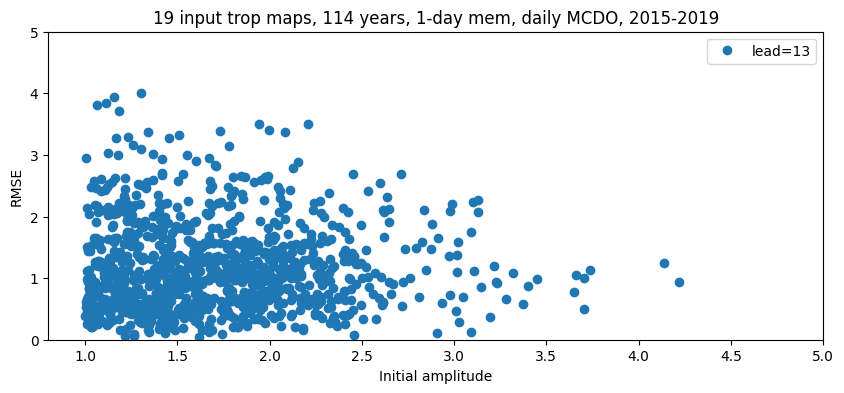

In [14]:
del ds1 
ilead = 3
ds1 = ds.copy()
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(ds1[ilead]['IniAmp'].values, ds1[ilead]['RMSE'].values, 'o', label='lead='+str(lead[ilead]))

ax.legend(ncol=len(lead))
ax.set_xlabel('Initial amplitude')
ax.set_ylabel('RMSE')
ax.set_ylim([0,5])
ax.set_xlim([0.8,5])
ax.set_title(str(varnum)+' input '+flg+' maps, '+str(yrlen)+' years, 1-day mem, daily MCDO, 2015-2019')

Text(0.5, 1.0, 'lead=20')

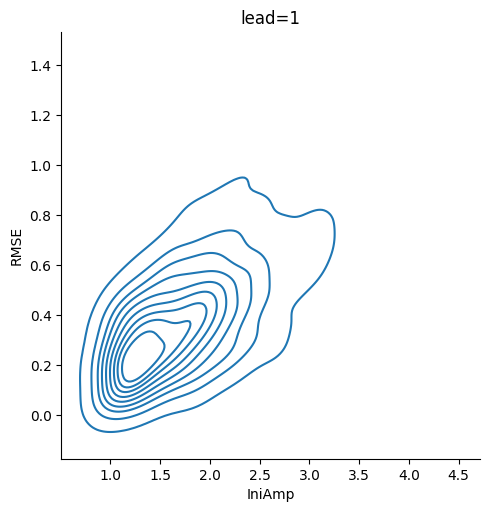

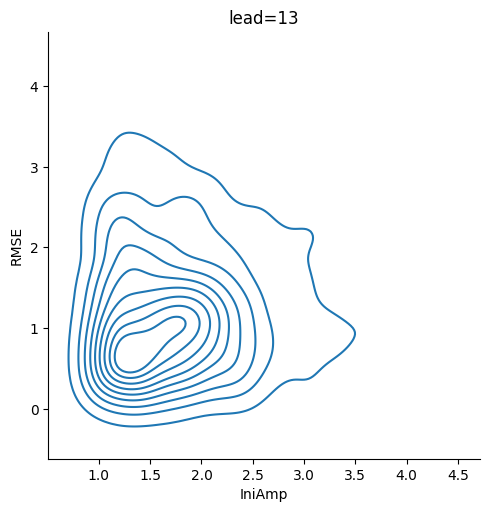

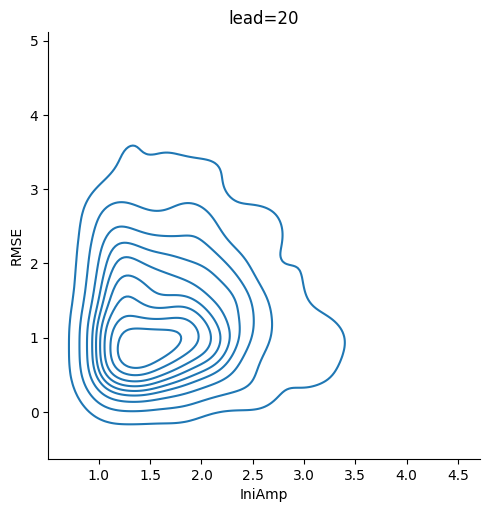

In [15]:
import seaborn as sns

ilead = 0
ds1 = pd.concat((ds[ilead].IniAmp, ds[ilead].RMSE),axis=1)
sns.displot(ds1, x="IniAmp", y="RMSE", kind="kde")
plt.title('lead=' + str(lead[ilead]))

ilead = 3
ds1 = pd.concat((ds[ilead].IniAmp, ds[ilead].RMSE),axis=1)
sns.displot(ds1, x="IniAmp", y="RMSE", kind="kde")
plt.title('lead=' + str(lead[ilead]))


ilead = 5
ds1 = pd.concat((ds[ilead].IniAmp, ds[ilead].RMSE),axis=1)
sns.displot(ds1, x="IniAmp", y="RMSE", kind="kde")
plt.title('lead=' + str(lead[ilead]))

# plt.ylabel('Density')
# plt.ylim([0,1.0])
# plt.xlabel('RMSE')
# plt.xlim([-0.1,5])


Below is for one input map runs.